# Color recognition

First we add the necessary imports.

In [11]:
import csv
import numpy as np
from PIL import Image
from collections import defaultdict
import pickle
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd


Here we declare some global with the localtion of the required files.

In [12]:
model_path = "color_classifier.pth"
label_encoder_path = "label_encoder.pkl"
image_path = "image.jpg"
csv_file = "colors.csv"

Same as in the other notebook here we declare the `ColorClassifier` instance of the model to be able to consume it later.

In [13]:
class ColorClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ColorClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

We define this helper function to get the colors of the image. The function loads the image at image_path using the PIL library, gets the pixel values as an array, normalizes the pixel values, and converts the array to a PyTorch tensor. It then applies the model to the tensor to get predicted indices for each pixel. It converts these indices back into color names using the `label_encoder`, and then counts the occurrences of each color name using a `defaultdict`. Finally, it returns the `color_counter`.

In [14]:
def get_image_colors(image_path, model, label_encoder):
    image = Image.open(image_path)
    pixels = np.array(image.getdata()) / 255.0
    pixels = torch.tensor(pixels, dtype=torch.float32)

    with torch.no_grad():
        model.eval()
        outputs = model(pixels)
        _, predicted_indices = torch.max(outputs, 1)
        color_names = label_encoder.inverse_transform(predicted_indices.numpy())

    color_counter = defaultdict(int)
    for color_name in color_names:
        color_counter[color_name] += 1

    return color_counter

Now with the following function we are able to get the RGB values from the CSV. This code defines a function called get_rgb_from_csv that takes in two arguments:

- `colors_list`: a list of color names to look up RGB values for
- `csv_file_path`: the path to a CSV file containing RGB values for various colors

The function loads the CSV file at `csv_file_path` using the csv library, and converts each row in the CSV file to a dictionary where the color name is the key and the RGB values are the values. It then loops through each color name in `colors_list`, looks up its RGB values in the `colors_dict` dictionary, and appends a tuple of the form (color_name, rgb) to the result list. If the color name is not found in the `colors_dict` dictionary, it appends `(color_name, None)` instead. The function ultimately returns the result list, which contains a list of tuples representing each color name and its corresponding RGB value (if available).

In [15]:
def get_rgb_from_csv(colors_list, csv_file_path):
    with open(csv_file_path, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        colors_dict = {row["Name"].lower(): (int(row["Red (8 bit)"]), int(row["Green (8 bit)"]), int(row["Blue (8 bit)"])) for row in reader}
    result = []
    for color_name in colors_list:
        if color_name.lower() in colors_dict:
            rgb = colors_dict[color_name.lower()]
            result.append((color_name, rgb))
        else:
            result.append((color_name, None))
    return result

We use this function to help us get the conversion of the values. The function unpacks the rgb tuple into separate variables r, g, and b, and then uses an f-string to format these values as a hexadecimal color code in the format #rrggbb. The :02x specifier is used to format each component as a two-digit hexadecimal number with leading zeros, ensuring that each component is represented by two characters.

For example, if rgb is (255, 0, 128), the function would return the string "#ff0080", which represents a bright pink color.

In [16]:
def rgb_to_hex(rgb):
    r, g, b = rgb
    return f"#{r:02x}{g:02x}{b:02x}"

Now we have the following function which help us to write the color names in a readable format.

In [17]:
def print_results(color_pixels, color_codes):
    print("RESULTS:\n")
    data = []
    for (color_name, rgb_val), (_, pixels) in zip(color_codes, color_pixels):
        data.append((color_name, rgb_val, pixels))
    print(pd.DataFrame(data, columns=["Color name", "RGB value", "Pixels"]))

And lastly we have this function to show the corresponding graph of the color % and detections of the image.

In [18]:
def show_graph(color_pixels, color_codes):
    color_graph_data = []
    for (color_name, rgb_val), (_, pixels) in zip(color_codes, color_pixels):
        color_graph_data.append((color_name, rgb_to_hex(rgb_val), pixels))

    pie_labels = [f"{i[0]}, {i[1]}" for i in color_codes]
    colors = [i[1] for i in color_graph_data]
    pixels = [i[2] for i in color_graph_data]

    plt.rcParams["figure.figsize"] = [12.8, 7.2]
    plt.pie(pixels, labels=pie_labels, colors=colors)
    plt.title("Color distribution", fontdict={"fontsize": 14, "fontweight": "bold"})
    plt.show()

This is the example image to get the colors from:

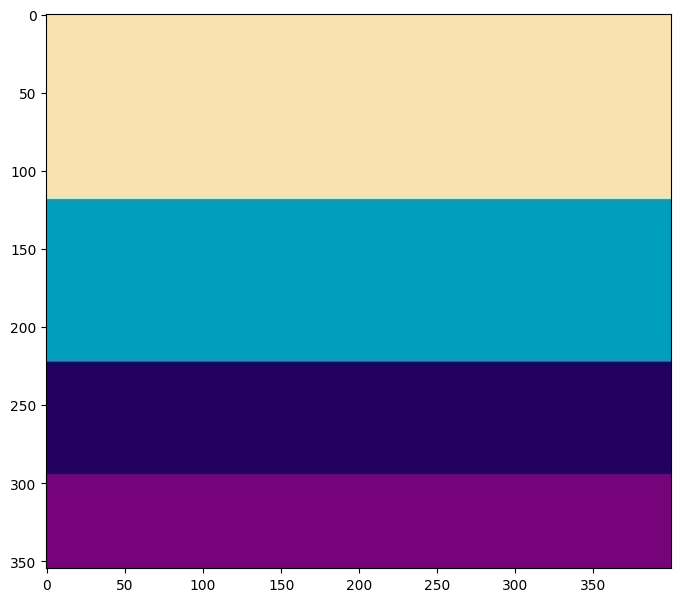

In [19]:
img = mpimg.imread(image_path)
plt.imshow(img)

And then we just have to consume the model, print the results and show the color graph in the following code:

RESULTS:

              Color name        RGB value  Pixels
0           Banana Mania  (250, 231, 181)   46800
1             Bondi blue    (0, 149, 182)   40000
2            Deep violet     (51, 0, 102)   28400
3          Purple (HTML)    (128, 0, 128)   23600
4                   Bone  (227, 218, 201)     400
5              Aero blue  (201, 255, 229)     400
6                   Zomp   (57, 167, 142)     400
7             Blue-green   (13, 152, 186)     400
8           Pacific Blue   (28, 169, 201)     400
9   Cyan cornflower blue   (24, 139, 194)     400
10         Midnight blue    (25, 25, 112)     400
11          Indigo (web)     (75, 0, 130)     400


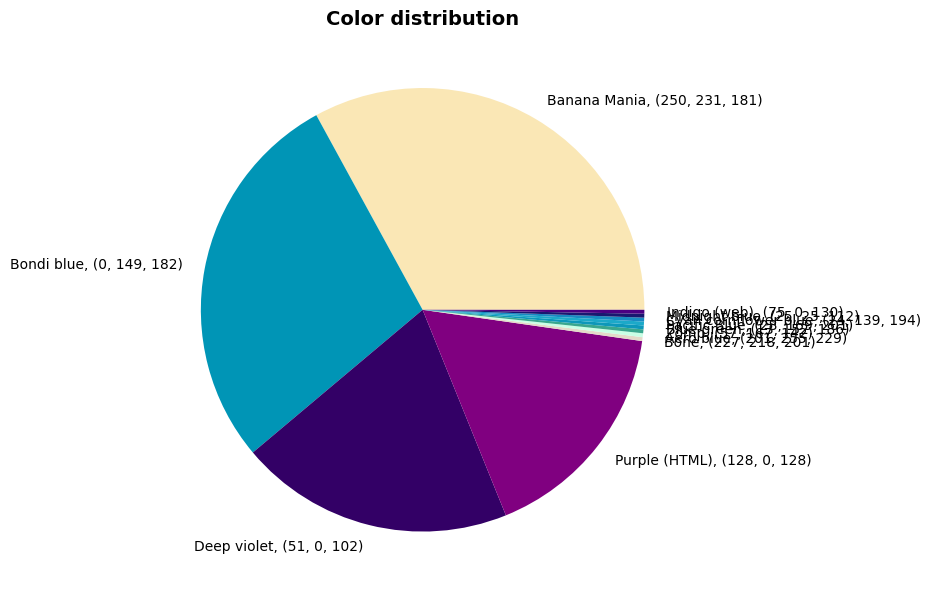

In [20]:
num_classes = 0
with open(label_encoder_path, "rb") as f:
    label_encoder = pickle.load(f)
    num_classes = len(label_encoder.classes_)

model = ColorClassifier(3, num_classes)
model.load_state_dict(torch.load(model_path))

image_colors = get_image_colors(image_path, model, label_encoder)

color_pixels = sorted(image_colors.items(), key=lambda x: x[1], reverse=True)

color_codes = get_rgb_from_csv([color[0] for color in color_pixels], csv_file)

print_results(color_pixels, color_codes)
show_graph(color_pixels, color_codes)